### Previously, we worked on building a logistic regression model that achieved around 70% accuracy on a skin cancer image dataset. This time we will try to build a Neural Network model. And just like before, we will try our best to build it without importing any ML libraries, so it stays transparent and we can understand what's going on in every line

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import cv2

dataset_path = '/kaggle/input/skin-cancer-binary-classification-dataset/Skin_Data'

# Initialize lists
images = []
labels = []

# Label map based on top-level folder names
label_map = {'Cancer': 1, 'Non_Cancer': 0}

# Walk through directory tree
for category in ['Cancer', 'Non_Cancer']:
    for split in ['Training', 'Testing']:
        folder_path = os.path.join(dataset_path, category, split)
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.png')):
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (64, 64))  # Resize to match model input
                images.append(img)
                labels.append(label_map[category])

# Convert to NumPy arrays
X = np.array(images) / 255.0  # Normalize pixel values
y = np.array(labels)

print("Loaded images shape:", X.shape)
print("Labels shape:", y.shape)


Loaded images shape: (288, 64, 64, 3)
Labels shape: (288,)


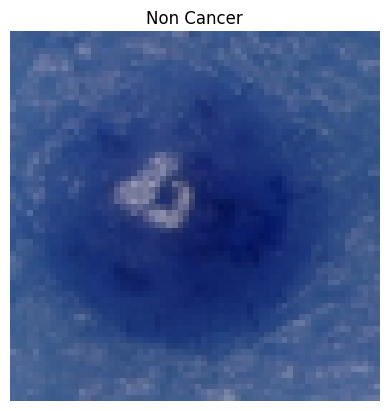

In [3]:
import matplotlib.pyplot as plt

idx = 142

plt.imshow(X[idx])
plt.axis('off')
plt.title("Cancer" if y[idx] == 1 else 'Non Cancer')
plt.show()

In [4]:
X = X / 255.0

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X_train.shape

(230, 64, 64, 3)

In [7]:
def conv_forward(X, W, b, stride=1, pad=0):
    # X: (m, H_prev, W_prev, C_prev)
    # W: (f, f, C_prev, C_out)
    m, H_prev, W_prev, _ = X.shape
    f, _, _, C_out = W.shape
    
    H = (H_prev - f + 2*pad) // stride + 1
    W_out = (W_prev - f + 2*pad) // stride + 1
    
    # Add zero padding if needed
    if pad > 0:
        X_pad = np.pad(X, ((0,0), (pad,pad), (pad,pad), (0,0)), mode='constant')
    else:
        X_pad = X
    
    Z = np.zeros((m, H, W_out, C_out))
    
    for h in range(H):
        for w in range(W_out):
            h_start = h * stride
            h_end = h_start + f
            w_start = w * stride
            w_end = w_start + f
            
            X_slice = X_pad[:, h_start:h_end, w_start:w_end, :]  # (m, f, f, C_prev)
            Z[:, h, w, :] = np.tensordot(X_slice, W, axes=([1,2,3], [0,1,2])) + b
            
    return Z  # (m, H, W_out, C_out)

In [8]:

def softmax(z):
    # Numerically stable version: subtract max(z) to avoid overflow
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [9]:
def avg_pool(X, f=2, stride=2):
    m, H_prev, W_prev, C = X.shape
    H = (H_prev - f) // stride + 1
    W_out = (W_prev - f) // stride + 1
    
    A = np.zeros((m, H, W_out, C))
    
    for h in range(H):
        for w in range(W_out):
            h_start = h * stride
            h_end = h_start + f
            w_start = w * stride
            w_end = w_start + f
            
            A[:, h, w, :] = np.mean(X[:, h_start:h_end, w_start:w_end, :], axis=(1,2))
            
    return A

In [10]:
# Initialize parameters
W1 = np.random.randn(5, 5, 3, 6) * 0.01
b1 = np.zeros(6)
W2 = np.random.randn(5, 5, 6, 16) * 0.01
b2 = np.zeros(16)
W3 = np.random.randn(13*13*16, 120) * 0.01
b3 = np.zeros(120)
W4 = np.random.randn(120, 84) * 0.01
b4 = np.zeros(84)
W5 = np.random.randn(84, 10) * 0.01  # Assuming 10 classes
b5 = np.zeros(10)

# Forward pass
def forward(X):
    # Conv1
    Z1 = conv_forward(X, W1, b1, stride=1, pad=0)  # (288, 60, 60, 6)
    A1 = np.tanh(Z1)  # LeNet uses tanh
    
    # Pool1
    P1 = avg_pool(A1)  # (288, 30, 30, 6)
    
    # Conv2
    Z2 = conv_forward(P1, W2, b2, stride=1, pad=0)  # (288, 26, 26, 16)
    A2 = np.tanh(Z2)
    
    # Pool2
    P2 = avg_pool(A2)  # (288, 13, 13, 16)
    
    # Flatten
    P2_flat = P2.reshape(P2.shape[0], -1)  # (288, 2704)
    
    # FC layers
    Z3 = P2_flat @ W3 + b3  # (288, 120)
    A3 = np.tanh(Z3)
    
    Z4 = A3 @ W4 + b4  # (288, 84)
    A4 = np.tanh(Z4)
    
    Z5 = A4 @ W5 + b5  # (288, 10)
    A5 = softmax(Z5)  # Output probabilities
    
    return A5

In [11]:
def cross_entropy_loss(y_pred, y_true):
    m = y_true.shape[0]
    log_probs = -np.log(y_pred[range(m), y_true])
    return np.sum(log_probs) / m

def train(X, y, epochs=1000, lr=0.01):
    for epoch in range(epochs):
        # Forward pass
        y_pred = forward(X)
        loss = cross_entropy_loss(y_pred, y)
        
        # Backward pass (implement this next)
        # ...
        
        # Update weights (example for W1)
        #W1 -= lr * dW1
        #b1 -= lr * db1
        
        if epoch % 1 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")

In [12]:
def evaluate(X, y_true, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5):
    y_pred = forward(X)  # Uses the forward() function defined earlier
    loss = cross_entropy_loss(y_pred, y_true)
    accuracy = np.mean(np.argmax(y_pred, axis=1) == y_true)
    return loss, accuracy

# After training:
train_loss, train_acc = evaluate(X_train, y_train, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5)
test_loss, test_acc = evaluate(X_test, y_test, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5)

print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")

Train Loss: 2.3026, Train Accuracy: 0.00%
Test Loss: 2.3026, Test Accuracy: 0.00%
